# Проект: классификация клинетов банка

In [1]:
#Импортирую необходимые, на первый взгляд, для работы библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Прочитаю данные, исследудю не предмет пропусков

In [49]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')#читаю данные

df.head()#убеждаюсь, что данные прочитаны верно

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [50]:
# исследую данные на предмет пропусков.
miss_col = [] #список пар наименования признака и кол-ва пропусков
for column in df.columns.values.tolist(): #цикл по всем признакам
   miss_col.append((df[column].isnull().sum(), column))#добавление пар в массив

print(sorted(list(filter(lambda x: x[0]!=0,miss_col)), key=lambda x: x[1], reverse=True)[0])#фильртарция и сортировка массива

(np.int64(25), 'balance')


In [51]:
# поиск возможных пропущенных значений, обозначенных специальным символом. Посмотрим какие значения есть в признаке job
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

*unknown* также является своего рода пропуском в данных. На это необходимо обращать внимание!

### Преобразование данных, работа с пропусками и признаками

In [52]:
# преобразую признак balance таким образом, чтобы он корректно считывался, как вещественное число (float) для заполнения пропусков
df['balance'] = df['balance'].apply(lambda x: x if type(x)==float else float(x.replace(' ','')[:-1].replace(',','.')))
#посмотрю на среднее значение по признаку
print(round(df['balance'].mean(),3))

1529.129


In [53]:
# обработаю пропуски в признаке balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
#посмотрю на среднее значение по признаку после заполнения пропусками
print(round(df['balance'].mean(),3))

1526.936


In [54]:
# обработаю пропуски в категориальных признаках: job и education, заменив их на модальные значения
df.loc[df['job']=='unknown','job'] = df['job'].mode()[0]
df.loc[df['education']=='unknown','education'] = df['education'].mode()[0]

In [55]:
#рассчитаю средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
print(round(df[(df['job']=='management') & (df['education']=='secondary')]['balance'].mean(),3))

1598.883


### Работа с выбросами

In [56]:
# удалю все выбросы для признака balance с помощью метода межквартильного размаха(Тьюки)
#инициализирую функцию
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75), #определяем квартили
    iqr = quartile_3 - quartile_1 #находим межквартильный размах
    lower_bound = quartile_1 - (iqr * 1.5)#определяем нижнюю границу
    upper_bound = quartile_3 + (iqr * 1.5)#определяем верхнюю границу
    outliers = data[(x < lower_bound) | (x > upper_bound)] #определяем выбросы
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)] #определяем очищенные данные
    print(lower_bound, upper_bound)
    return outliers, cleaned
#воспользуюсь функцией на наших данных для признака balance
outliers, df_cl = outliers_iqr(df,'balance')

-2241.0 4063.0


In [57]:
print(f"Объектов после удаления всех выбросов осталось: {df_cl.shape[0]}")

Объектов после удаления всех выбросов осталось: 10105


## Часть 2:  Разведывательный анализ

In [ ]:
# изучу соотношение классов в  данных на предмет несбалансированности
dep_data = df_cl['deposit'].value_counts()
dep_data.rename(index={'no': 'Не открыли', 'yes': 'Открыли'}, inplace=True)
print(dep_data.loc['Открыли'])

fig = px.pie(dep_data, values=dep_data, names=dep_data.index, title = 'Соотношение между клинетами по признаку открытия депозита')
fig.update_layout(height=600,
                  width=650,
)
fig.show()

4681


In [ ]:
#рассчитаю описательные статистики для количественных переменных
df_cl.describe()


,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [ ]:
#посмотрю на матрицы рассеивания признаков для формирования предварительных выводов о зависимостях в данных
fig = px.scatter_matrix(df_cl, dimensions=["age", "balance", "duration", "campaign",'previous'], color="deposit", title='Матрицы рассеивания по числовым признакам в разрезе наличия депозитов')
fig.update_layout(height=600,
                  width=1250,
)
fig.show()

In [ ]:
#посмотрю на распределения отдельных числовых признаков в разрезе наличия депозита в банке
for col in ["age", "balance", "duration", "campaign",'previous','pdays']:
  fig = px.histogram(
    df_cl,
    x=col,
    color='deposit',
    nbins=50,
    marginal="box",
    barmode='group',
    height=500,
    width=800,
    title=f'Распределение {col} в разрезе наличия депозита',
    )
  fig.show()

Заметно, что после 60-ти лет соотношение клиентов по наличию депозита резко повышаются в сторону имеющих, такое же прослеживается и с увеличением баланса. Похоже, что увеличение длительности контакта с клиентом также говорит о положительном влиянии на открытие депозита, а вот количество контактов говорит об обратном.

In [ ]:
#рассчитаю описательные статистики для категориальных переменных
df_cl.describe(include='object')


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [ ]:
#Посмотрим на соотношения признаков в разарезе признака депозита
for col in ['job',	'marital',	'education',	'default',	'housing',	'loan', 'contact',	'month',	'poutcome']:
  fig = px.histogram(df_cl, 
                     x=col, 
                     color='deposit', 
                     title=f"Соотношение {col} в разрезе признака депозита",
                     barmode='group', 
                     height=500,
                     width=800)
  fig.show()

По визуальному анализу данных напрашиваются следюущие выводы:
1. Определенно результат прошлой маркетинговой кампании влияет на текущую
2. В декбаря, январе, марте и сентябре маркетинговая компания была проведена на более высоком уровне, чем в остальные месяцы.
3. Отсутствие кредита на жилье, на первый взгляд, вляет на наличие депозита

In [ ]:
#Посмотрим на соотношение результатов прошлой маркетинговой компании в разарезе признака открытия депозита
fig = px.histogram(df_cl, 
                   x='poutcome', 
                   color='deposit', 
                   title="Соотношение результатов прошлой маркетинговой компании в разарезе признака депозита",   
                   height=500,
                   width=1000)
fig.show()

In [ ]:
# Посмотрим, в каком месяце чаще всего отказывались от предложения открыть депозит
df_cl[df_cl['deposit']=='no'].groupby(['month']).size()/df_cl.groupby(['month']).size()

month
apr    0.381928
aug    0.559567
dec    0.096774
feb    0.455571
jan    0.608150
jul    0.589563
jun    0.548913
mar    0.101266
may    0.678640
nov    0.584615
oct    0.185075
sep    0.165468
dtype: float64

In [ ]:
# создам возрастные группы и определю, в каких группах более склонны открывать депозит, чем отказываться от предложения
def classif_age(x):
  if x<30:
    return "<30"
  elif x<40:
    return '30-40'
  elif x<50:
    return '40-50'
  elif x<60:
    return '50-60'
  elif x>=60:
    return '60+'

df_cl['age_group'] = df_cl['age'].apply(classif_age)

In [ ]:
fig = px.histogram(df_cl, 
                   x='age_group', 
                   color='deposit', 
                   title=f"Соотношение возрастных групп в разрезе признака депозита",   
                   height=500,
                   width=800)
fig.show()

In [ ]:
# Посмотрим как соотносятся открывшие и неоткрывшие депозит в зависимости от семейного статуса
fig = px.histogram(df_cl, 
                   x='marital', 
                   color='deposit', 
                   title=f"Соотношение возрастных групп в разрезе признака депозита",   
                   height=500,
                   width=800)
fig.show()

In [ ]:
#  Посмотрим как соотносятся открывшие и неоткрывшие депозит в зависимости от образования
fig = px.histogram(df_cl, 
                   x='education', 
                   color='deposit', 
                   title=f"Соотношение возрастных групп в разрезе признака депозита",   
                   height=500,
                   width=800)
fig.show()

In [ ]:
#  Посмотрим как соотносятся открывшие и неоткрывшие депозит в зависимости от вида профессиональной занятости
fig = px.histogram(df_cl, 
                   x='job', 
                   color='deposit', 
                   title=f"Соотношение возрастных групп в разрезе признака депозита",   
                   height=500,
                   width=800)
fig.show()

In [ ]:
# Построю сводную таблицу, чтобы определить, люди с каким образованием и семейным статусом наиболее многочисленны
no_dep_data = df_cl[df_cl['deposit']=='no']

yes_dep_data = pd.pivot_table(df_cl[df_cl['deposit']=='yes'], index='education', columns='marital',values='deposit', aggfunc='count')#сводная табица для открывших депозит
no_dep_data = pd.pivot_table(df_cl[df_cl['deposit']=='no'], index='education', columns='marital',values='deposit', aggfunc='count')#сводная табица для неоткрывших депозит

fig = px.imshow(yes_dep_data, text_auto=True, width=700, title='Тепловая карта распределения клиентов, открывших депозит')
fig.show()

fig = px.imshow(no_dep_data, text_auto=True, width=700, title='Тепловая карта распределения клиентов, неоткрывших депозит')
fig.show()

## Часть 3: преобразование данных

In [ ]:
# преобразую уровни образования с помощью порядкового кодирования
le_edu = LabelEncoder()
df_cl['education'] = le_edu.fit_transform(df_cl['education'])

In [ ]:
# преобразую порядковую переменную возраста с помощью порядкового кодирования
le_age = LabelEncoder()
df_cl['age_group'] = le_edu.fit_transform(df_cl['age_group'])

In [ ]:
# преобразую бинарные переменные в представление из нулей и единиц
def bin_enc(x):
  if x == 'yes':
    return 1
  else: 
    return 0

for col in ['deposit', 'loan', 'housing', 'default']:
  df_cl[col] = df_cl[col].apply(bin_enc)

In [ ]:
# создам дамми-переменные из оставшихся категориальных переменных
df_cl = pd.get_dummies(df_cl, ['job', 'marital', 'contact', 'month', 'poutcome'])

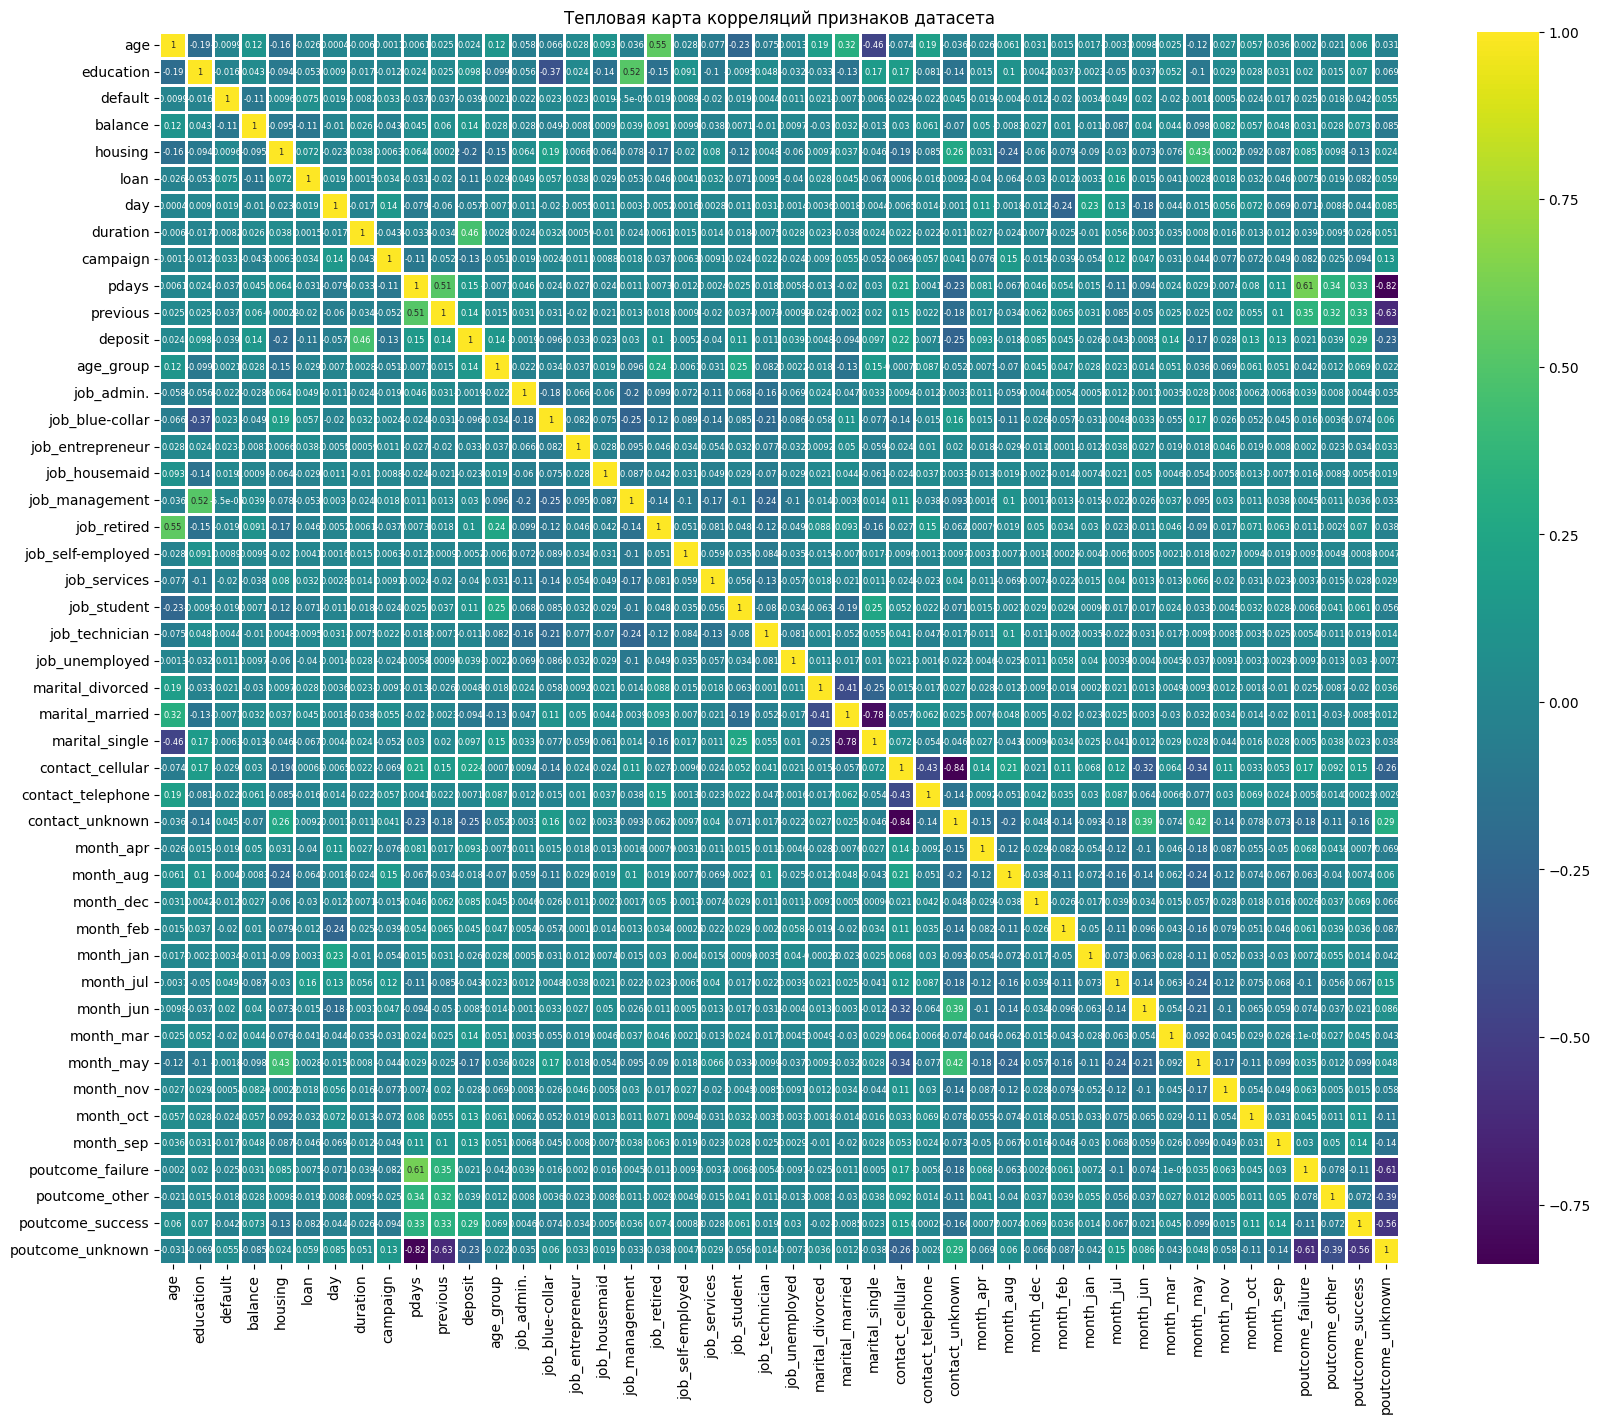

In [ ]:
# построю корреляционную матрицу и оценю данные на предмет наличия мультиколлинеарности
fig, axes = plt.subplots(figsize=(20, 16))
df_cl_heatmap = sns.heatmap(
    df_cl.corr(),
    linewidth=1,
    linecolor='w',
    cmap='viridis',
    ax = axes,
    annot=True,
    annot_kws={"fontsize":6}
)
df_cl_heatmap.set_title('Тепловая карта корреляций признаков датасета');

In [ ]:
#выделю целевую переменную в отделеный набор данных
X = df_cl.drop(['deposit'], axis=1)
y = df_cl['deposit']
#разобью данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# посмотрю на размер тестовой выборки и среднее значение целевой переменной
print(f'Размер тестовой выборки: {X_test.shape[0]}')
print(f'Среднее значение целевой переменной на тестовой выборке: {round(y_test.mean(),2)}')

Размер тестовой выборки: 3335
Среднее значение целевой переменной на тестовой выборке: 0.46


In [ ]:
# с помощью SelectKBest отберу 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

X_train_select = pd.DataFrame(columns=selector.get_feature_names_out(), data=selector.transform(X_train))
X_test_select = pd.DataFrame(columns=selector.get_feature_names_out(), data=selector.transform(X_test))

In [ ]:
# нормализую данные с помощью minmaxsxaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_select)

X_train_scaled = X_train_select.copy()
X_test_scaled = X_test_select.copy()

X_train_scaled[X_train_select.columns] = mm_scaler.fit_transform(X_train_select.values)
X_test_scaled[X_test_select.columns] = mm_scaler.transform(X_test_select.values)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [ ]:
# обучу логистическую регрессию и посмотрю на точность модели
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_test_pred_lg = log_reg.predict(X_test_scaled)
print(np.round(metrics.accuracy_score(y_test,y_test_pred_lg),3))

0.81


In [ ]:
# обучу решающие деревья и посмотрю на точность модели
tree_cls = tree.DecisionTreeClassifier(criterion = 'entropy',  random_state=42, class_weight='balanced')
tree_cls.fit(X_train_scaled, y_train)

y_test_pred_lg_tr = tree_cls.predict(X_test_scaled)
y_train_pred_lg_tr = tree_cls.predict(X_train_scaled)
print(np.round(metrics.accuracy_score(y_test,y_test_pred_lg_tr),3))
print(np.round(metrics.accuracy_score(y_train,y_train_pred_lg_tr),3))

0.748
1.0


In [ ]:
#посмотрю на метрики модели с уточненной максимальной глубиной дерева, для исключения переобучения
tree_cls = tree.DecisionTreeClassifier(criterion = 'entropy',  random_state=42, max_depth=6, class_weight='balanced')
tree_cls.fit(X_train_scaled, y_train)

y_test_pred_lg_tr = tree_cls.predict(X_test_scaled)
y_train_pred_lg_tr = tree_cls.predict(X_train_scaled)
print(np.round(metrics.accuracy_score(y_test,y_test_pred_lg_tr),2))
print(np.round(metrics.accuracy_score(y_train,y_train_pred_lg_tr),2))

0.81
0.82


In [ ]:
# подберу оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_split': [2, 5, 7, 10],#минимальное количество листьев
              'max_depth':[3,5,7], #макисмальная глубина дерева
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy',
        class_weight='balanced',
        random_state=42
    ), 
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs = -1
)
grid_search.fit(X_train_scaled, y_train)
#выведу лучшие значения гиперпараметров
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

y_test_pred_gs = grid_search.predict(X_test_scaled)
#выведу значение метрики f1 для подобранных гиперпараметров
print('f1_score на тестовом наборе: {:.2f}'.format(round(metrics.f1_score(y_test, y_test_pred_gs),2)))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}
f1_score на тестовом наборе: 0.81


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [ ]:
# обучу на данных случайный лес и посмотрю на значение метрик
forest_model = ensemble.RandomForestClassifier(
                      n_estimators=100,
                      criterion='gini',
                      min_samples_leaf=5,
                      max_depth=10,
                      random_state=42,
                      class_weight='balanced'
)

forest_model.fit(X_train_scaled, y_train)

y_test_pred_forest = forest_model.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_test_pred_forest))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test,y_test_pred_forest))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1790
           1       0.79      0.85      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Confusion matrix
[[1447  343]
 [ 231 1314]]


In [ ]:
# использую для классификации градиентный бустинг и сравню его качество со случайным лесом
g_boost = ensemble.GradientBoostingClassifier(
                  learning_rate=0.05,
                  n_estimators=300,
                  min_samples_leaf=5,
                  max_depth=5,
                  random_state=42
)
g_boost.fit(X_train_scaled, y_train)

y_test_pred_gb = g_boost.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_test_pred_gb))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test,y_test_pred_gb))


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Confusion matrix
[[1472  318]
 [ 259 1286]]


In [ ]:
# объединю уже известные алгоритмы с помощью стекинга и посмотрю на метрику precision
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000,class_weight='balanced')),
    ('dt', tree.DecisionTreeClassifier(max_depth=7, min_samples_split=10, criterion='entropy', random_state=42,class_weight='balanced')),
    ('gb', ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42))
]

stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000,class_weight='balanced')
)

stack.fit(X_train_scaled, y_train)

y_test_pred_stack = stack.predict(X_test_scaled)
print(round(metrics.precision_score(y_test,y_test_pred_gb),2))

0.8


In [ ]:
# оценю, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
feat_importances = pd.Series(g_boost.feature_importances_, index=X_test_scaled.columns)
fig = px.bar(feat_importances.nlargest(3), 
             title='Три наиболее важных признака для модели градиентного бустинга',
             width=700,
             height=700,
             labels={'index': 'Признаки', 'value':"Важность"},
)
fig.update(layout_showlegend=False)
fig.show()

In [ ]:
# реализую оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42,
                                          class_weight='balanced')
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [ ]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-02-08 15:05:52,585] A new study created in memory with name: RandomForestClassifier
[I 2025-02-08 15:05:53,093] Trial 0 finished with value: 0.8603831417624521 and parameters: {'n_estimators': 138, 'max_depth': 29, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8603831417624521.
[I 2025-02-08 15:05:53,846] Trial 1 finished with value: 0.8794085938703219 and parameters: {'n_estimators': 183, 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8794085938703219.
[I 2025-02-08 15:05:54,770] Trial 2 finished with value: 0.9224553224553225 and parameters: {'n_estimators': 197, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9224553224553225.
[I 2025-02-08 15:05:55,386] Trial 3 finished with value: 0.8767123287671232 and parameters: {'n_estimators': 147, 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9224553224553225.
[I 2025-02-08 15:05:55,999] Trial 4 finished with value: 0.8643833512517278 and parameters: {'n_

In [ ]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 169, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [ ]:
# рассчитаю метрики для тестовой выборки с уточненными гиперпараметрами
model_rf_opt = ensemble.RandomForestClassifier(**study.best_params,random_state=42, class_weight='balanced')
model_rf_opt.fit(X_train_scaled, y_train)

y_test_pred_opt = model_rf_opt.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1790
           1       0.79      0.85      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

